In [3]:
#### RUN THE CELL TWICE FOR SOME REASON 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os 
import os
CONDA_PREFIX = os.environ["CONDA_PREFIX"]
LD_LIBRARY_PATH = os.environ["LD_LIBRARY_PATH"]

%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/python3.8/site-packages/tensorrt/
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,2
%env TF_ENABLE_ONEDNN_OPTS=0
%env TOKENIZERS_PARALLELISM = true

print(os.environ["LD_LIBRARY_PATH"])

env: LD_LIBRARY_PATH=/usr/local/cuda/lib64:/home/coler/anaconda3/envs/covid_proj/lib/:/home/coler/anaconda3/envs/covid_proj/lib/python3.8/site-packages/nvidia/cudnn/lib:/home/coler/anaconda3/envs/covid_proj/lib/python3.8/site-packages/tensorrt/:/home/coler/anaconda3/envs/covid_proj/lib/python3.8/site-packages/tensorrt/
env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0,2
env: TF_ENABLE_ONEDNN_OPTS=0
env: TOKENIZERS_PARALLELISM=true
/usr/local/cuda/lib64:/home/coler/anaconda3/envs/covid_proj/lib/:/home/coler/anaconda3/envs/covid_proj/lib/python3.8/site-packages/nvidia/cudnn/lib:/home/coler/anaconda3/envs/covid_proj/lib/python3.8/site-packages/tensorrt/:/home/coler/anaconda3/envs/covid_proj/lib/python3.8/site-packages/tensorrt/


In [4]:
### VERIFY TF
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
import getpass
pw = getpass.getpass() #ONLY necessary to clean /tmp folder; see notes below

 ········


In [6]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
import os
import random
from tqdm.notebook import tqdm as prog_bar
from glob import glob

# import ktrain
# from ktrain import text
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report as cr

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import tensorflow as tf
tf.__version__

'2.10.0'

In [7]:
df = pd.read_excel("../covid_proj_data/working_data/working_covid_data.xlsx")
df.label = df.label.apply(lambda lab: "SICK_TALK" if lab == "accept" else "HEALTHY_TALK")

lang_dict = dict(
    spanish = "es",
    english = "en",
    italian = "it",
    polish = "pl",
    german = "de",
    french = "fr"
    )
df["lang"] = df.language.apply(lambda lang: lang_dict[lang])

df.head()

,tweet_id,text,label_1,language,label_2,agreed_label,label,lang
0,1209309766616571904,@mentalnamadre nie chce byc natretna I wiem że...,reject,polish,reject,NaN,HEALTHY_TALK,pl
1,1209343971215991040,@KrzysztofWaj11 Ulala! To ze mną jeszcze nie j...,reject,polish,reject,NaN,HEALTHY_TALK,pl
2,1209352618130231040,"@CzesioDrugabe Trochę to chore, piszac delikat...",reject,polish,reject,NaN,HEALTHY_TALK,pl
3,1209403505242456064,@miloszlodowski Sędziowie od kiełbasy czy wier...,reject,polish,reject,NaN,HEALTHY_TALK,pl
4,1209415186408443904,@robertzielinski To demokratyczna przypadłość....,reject,polish,reject,NaN,HEALTHY_TALK,pl


In [17]:
# CV with transformers
CATS = ["HEALTHY_TALK","SICK_TALK"]
# MODEL_NAME = 'xlm-mlm-100-1280'
# MULTILINGUAL MODELS ON HUGGINGFACE, see: https://huggingface.co/docs/transformers/multilingual
# MODEL NAMES 
MODEL_NAMES = ["xlm-mlm-100-1280",
               "xlm-mlm-17-1280",
               "bert-base-multilingual-uncased",
               "bert-base-multilingual-cased",
               "xlm-roberta-base",
               "xlm-roberta-large"]

EPOCHS = 8
BATCH = 12
TEXT_COL = "text"
LABEL_COL = "label"
CHK = "chkpnts"
MODELS="models"
RES = "results"
MET = "both"
EXP_NAME = "./within_lang"
CMD = "sudo -S find /tmp/ -user coler -exec rm -fr {} \;" #THIS LINE defines a command which deletes keras files from /tmp; remove it or alter is to run locally

In [10]:
# ### CLASS WEIGHTS

# To be more precise, the formula to calculate this is:

# wj=n_samples / (n_classes * n_samplesj)

# Here,

# wj is the weight for each class(j signifies the class)
# n_samplesis the total number of samples or rows in the dataset
# n_classesis the total number of unique classes in the target
# n_samplesjis the total number of rows of the respective class
# For our heart stroke example:

# n_samples=  43400,  n_classes= 2(0&1), n_sample0= 42617, n_samples1= 783

# Weights for class 0:

# w0=  43400/(2*42617) = 0.509

# Weights for class 1:

# w1= 43400/(2*783) = 27.713
# def make_class_weights(df,ylab="label"):
#     class_weights = dict(df[ylab].value_counts().apply(lambda n_samples_lab: df.shape[0] / (len(CATS)*n_samples_lab)))
#     print(class_weights)
#     cw = {idx:class_weights[lab] for idx,lab in enumerate(CATS)}
#     print(cw)
#     return cw
# cw = make_class_weights(df)

In [9]:
!rm -r $EXP_NAME
!mkdir $EXP_NAME

!mkdir $EXP_NAME/$MODELS
!mkdir $EXP_NAME/$CHK
!mkdir $EXP_NAME/$RES

/bin/bash: /home/coler/anaconda3/envs/covid_proj/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/coler/anaconda3/envs/covid_proj/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/coler/anaconda3/envs/covid_proj/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/coler/anaconda3/envs/covid_proj/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/coler/anaconda3/envs/covid_proj/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [11]:
# !git clone git@github.com:amaiya/ktrain.git
# !git clone git@github.com:huggingface/transformers.git
# import _transformers.src.transformers as transformers
# import _ktrain.ktrain as ktrain
# from _ktrain.ktrain import text

In [12]:
import os
import numpy as np
import random
import pandas as pd

import tensorflow as tf
import ktrain
from ktrain import text

def reset_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
def multimax(lst):
    return list(np.argwhere(lst == np.amax(lst)).flatten())
    
def load_best_epoch(learner,metric):
    if metric == "val_loss":
        res = learner.history.history[metric]
        return res.index(min(res)) + 1
    elif metric == "val_accuracy":
        res = learner.history.history[metric]
        return res.index(max(res)) + 1
    elif metric == "both":
        accu = learner.history.history["val_accuracy"]
        loss = learner.history.history["val_loss"]
        dat = pd.DataFrame(dict(acc = accu,
                                lss = loss))
        best_acc = dat.loc[multimax(dat.acc.to_list()),:]
        res = best_acc.loc[best_acc.lss == best_acc.lss.min(),:].index[0]
        return res + 1
    
class KTrans(text.Transformer):
    model_load_type = "ktrain"
    def __init__(self,
                 model_name,
                 lr_dict=None,
                 class_weight=None
                ):
        super().__init__(model_name)
        self.model_name = model_name
        self.lr_dict = lr_dict
        self.class_weight = class_weight
            
    
    def make_data(self,train,val):
        X_train=train.loc[:,TEXT_COL].values
        X_val=val.loc[:,TEXT_COL].values
        y_train=train.loc[:,LABEL_COL].values
        y_val=val.loc[:,LABEL_COL].values
        
        #preprocess
        self.trn = self.preprocess_train(X_train, y_train)
        self.val = self.preprocess_test(X_val, y_val)
        
    def make_learner(self):
        model = self.get_classifier()
        return ktrain.get_learner(model, train_data=self.trn, val_data = self.val,batch_size=BATCH)
        
    def run_learning_rate(self,train,val,max_epochs):
        self.make_data(train,val)
        learner = self.make_learner()
        learner.lr_find(show_plot=True, suggest=True,max_epochs=max_epochs)
        
    def run_fit(self,train,val):
        self.make_data(train,val)
        self.learner = self.make_learner()
        
        save = f'{EXP_NAME}/{CHK}/{self.model_name}'
        if self.lr_dict:
            self.learner.fit_onecycle(self.lr_dict[self.model_name], EPOCHS,class_weight=self.class_weight,checkpoint_folder=save)
        else:
            self.learner.fit_onecycle(LEARN_RATE, EPOCHS,class_weight=self.class_weight,checkpoint_folder=save)
        best_epoch = load_best_epoch(self.learner,MET)
        print(f"best epoch was: {best_epoch}")
        if best_epoch == EPOCHS-1:
            print("Best epoch was last epoch")
        else:
            self.learner.model.load_weights(f'{save}/weights-{best_epoch:02d}.hdf5')
        
    def save_predictor(self,save_path):
        predictor = ktrain.get_predictor(self.learner.model,self)
        predictor.save(save_path)
        
    def run_predict(self,data,load_path=None,predict_proba=True):
        data=data.loc[:,TEXT_COL].values
        #load predictor
        if load_path:
            predictor = ktrain.load_predictor(load_path)
        else:
            predictor = ktrain.get_predictor(self.learner.model, self)
        if predict_proba:
            return predictor.predict_proba(data)
        else:
            return np.array(predictor.predict(data))

In [13]:
if True:
    from sklearn.model_selection import train_test_split as tts

    train,test = tts(df, test_size=0.1,random_state=42, shuffle=True, stratify=None)

    RUN_LOOP = False
    if RUN_LOOP:
        for model_name in MODEL_NAMES:
            #define model and fit
            mod = KTrans(model_name)
            print(f"\n\n\n Learning rate for: {model_name}\n\n\n")
            mod.run_learning_rate(train,test,4)

    RUN_SINGLE = False
    if RUN_SINGLE:
        single_name = input("Write in model name: ")
        mod = KTrans(single_name)
        print(f"\n\n\n Learning rate for: {single_name}\n\n\n")
        mod.run_learning_rate(train,test,4)
        


In [14]:
lr_dict = {'xlm-mlm-100-1280': 1.71E-06,
           'xlm-mlm-17-1280': 3.64E-06,
           'bert-base-multilingual-uncased': 1.78E-06,
           'bert-base-multilingual-cased': 1.50E-06,
           'xlm-roberta-base': 2.27E-06,
           'xlm-roberta-large': 1.07E-06}

In [15]:
def down_sample(data,
                ratio=1,
                minor="SICK_TALK",
                major="HEALTHY_TALK"):
    counts = data.loc[:,LABEL_COL].value_counts()
    f = ratio*(counts[minor]/counts[major])
    return pd.concat([data.loc[(data.label == major),:].sample(frac=f),data.loc[(data.label == minor),:]]).sample(frac=1).reset_index(drop=True)

test = down_sample(df.loc[df.language == "english"])
test.label.value_counts()
# test

HEALTHY_TALK    248
SICK_TALK       248
Name: label, dtype: int64

In [19]:
def get_save_path(fold_no):
    return f"{EXP_NAME}/{MODELS}/language_{fold_no}/{MODEL_NAME}"

def evaluate(boot_train,boot_val,fold_no,model_name,class_weight=None,lr_dict=None,save=False,del_mod=True):
    #define model and fit
    mod = KTrans(model_name,lr_dict,class_weight=class_weight)
    mod.run_fit(boot_train,boot_val)
    if save:
        save_path = get_save_path(fold_no)
        mod.save_predictor(save_path)
    #save validation predictions
    boot_val["pred"] = mod.run_predict(boot_val,predict_proba=False)
    if del_mod:
        del mod
    return boot_val

def run_cv(k,df,model_name,class_weight=None,lr_dict=None,early_break=None):
    vals=pd.DataFrame()
    data = df.copy()#loc[:,[TEXT_COL,LABEL_COL]]
    indexes = KFold(10,shuffle=True,random_state=42).split(data)
    for fold_no, index in enumerate(prog_bar(indexes,desc=f"Progress through CV")):
        train = data.iloc[index[0]]
        val = data.iloc[index[1]].copy()
        reset_random_seeds()
        #train and get predictions
        res = evaluate(train,val,fold_no,model_name,class_weight=class_weight,lr_dict=lr_dict,save=False)
        #save metadata
        res["fold_no"] = fold_no
        vals = pd.concat([vals,res],axis=0)
        os.system('echo %s | %s' % (pw, CMD)) #REMOVE THIS LINE TO *NOT* delete /tmp files each fold
        print(f"Fold no: {fold_no+1}")
        print(f"Model name: {model_name}")
        if early_break and fold_no == early_break:
            break
    return vals


def run_within(k,ratio,class_weight=None):
    result = pd.DataFrame()
    for lang in prog_bar(set(df.language),desc="Runing languages"):
        dat = df.loc[df.language == lang,:]
        ds_dat = down_sample(dat,ratio)    
        for model_name in prog_bar(MODEL_NAMES,desc="Runing models"):
            res = run_cv(k,ds_dat,model_name,class_weight=class_weight,lr_dict=lr_dict)
            res["model_name"] = model_name
            res.to_pickle(f"{EXP_NAME}/{RES}/{model_name}_results.pkl")
            result = pd.concat([result,res],axis=0)
    return result


In [ ]:
result = run_within(k = 10,ratio=1)

In [92]:
result.to_csv(f"{EXP_NAME}/results/all_results.pkl")

In [23]:
result.head()

,tweet_id,text,label_1,language,label_2,agreed_label,label,lang,pred,fold_no,model_name
0,1086735261378204032,Mi accompagnerai all'altare. C' è del disagio ...,reject,italian,reject,NaN,HEALTHY_TALK,it,HEALTHY_TALK,0,xlm-mlm-100-1280
2,1195746112147279872,E ci mancava l’influenza intestinale. I regali...,accept,italian,accept,NaN,SICK_TALK,it,SICK_TALK,0,xlm-mlm-100-1280
9,978674539000487936,@Zippo88lrr @vitoperrino @PillerGumpel @Patriz...,reject,italian,reject,NaN,HEALTHY_TALK,it,HEALTHY_TALK,0,xlm-mlm-100-1280
11,988887649049108480,@RiscattoNaz So distrutto da dolore......,accept,italian,reject,accept,SICK_TALK,it,HEALTHY_TALK,0,xlm-mlm-100-1280
30,976564888783982592,ho mal di pancia e mal di testa e male a tutto...,accept,italian,accept,NaN,SICK_TALK,it,SICK_TALK,0,xlm-mlm-100-1280


In [61]:
from sklearn.metrics import classification_report as cr

f1 = pd.DataFrame()

for mod,dx in result.groupby(["model_name","language"]):
    dic = {lab:[cr(dx["label"],dx["pred"],output_dict=True)[lab]["f1-score"]] for lab in CATS}
    dat = pd.DataFrame(dic)
    dat.index = pd.MultiIndex.from_tuples([mod], names=('model_name', 'language'))
    f1 = f1.append(dat)

f1.reset_index(drop=False,inplace=True)
f1

/home/coler/anaconda3/envs/covid_proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/coler/anaconda3/envs/covid_proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/coler/anaconda3/envs/covid_proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/coler/anaconda3/envs/covid_proj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and

,model_name,language,HEALTHY_TALK,SICK_TALK
0,bert-base-multilingual-cased,english,0.682446,0.668041
1,bert-base-multilingual-cased,french,0.763116,0.775940
2,bert-base-multilingual-cased,german,0.857464,0.865608
3,bert-base-multilingual-cased,italian,0.755382,0.742268
4,bert-base-multilingual-cased,polish,0.767606,0.720339
5,bert-base-multilingual-cased,spanish,0.794203,0.776025
6,bert-base-multilingual-uncased,english,0.634656,0.658869
7,bert-base-multilingual-uncased,french,0.821830,0.834575
8,bert-base-multilingual-uncased,german,0.882682,0.888417
9,bert-base-multilingual-uncased,italian,0.808679,0.801636


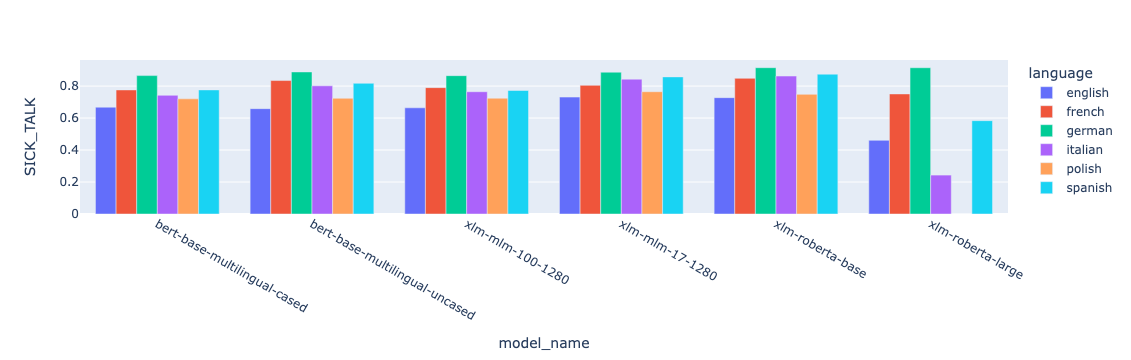

In [75]:
import plotly_express as px
px.bar(f1,
       x="model_name",
       y="SICK_TALK",
       color="language",
       barmode="group")


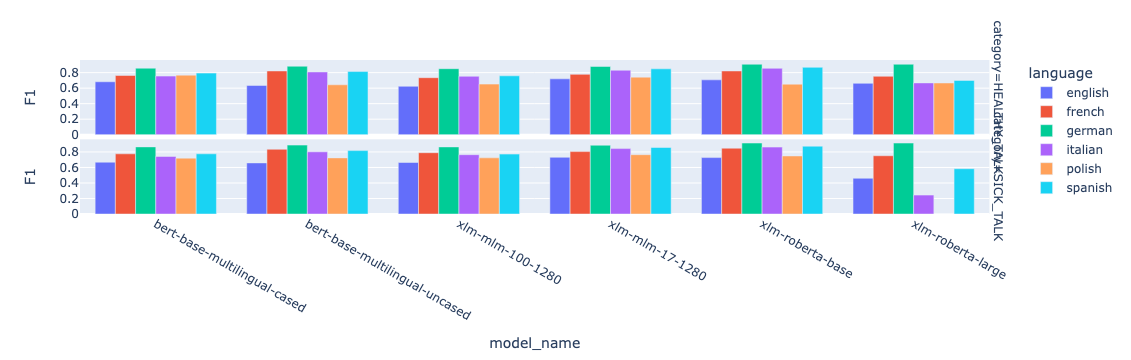

In [79]:
# f1.pivot(columns=["F1"],values=CATS)
long_f1 = f1.melt(id_vars=["model_name","language"],value_vars=CATS,value_name="F1",var_name="category")
px.bar(long_f1,
       x="model_name",
       y="F1",
       facet_row="category",
       color="language",
       barmode="group")


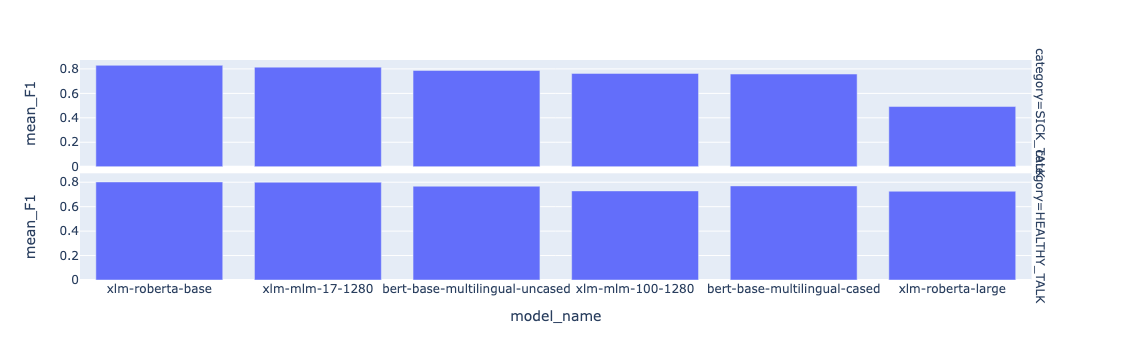

In [94]:
agg_f1 = long_f1.groupby(["model_name","category"]).\
    agg(mean_F1=("F1","mean")).\
    reset_index(drop=False,inplace=False).\
    sort_values(by="mean_F1",ascending=False)

px.bar(agg_f1,
       x="model_name",
       y="mean_F1",
       facet_row="category",
       # color="language",
       barmode="group")
# agg_f1

In [98]:
MOD = "xlm-mlm-17-1280"
best_res = result.loc[result.model_name == MOD,:]
for lang,dx in best_res.groupby("language"):
    print(f"{lang} : \n\n {cr(dx.label,dx.pred)}")

english : 

               precision    recall  f1-score   support

HEALTHY_TALK       0.74      0.71      0.72       248
   SICK_TALK       0.72      0.75      0.73       248

    accuracy                           0.73       496
   macro avg       0.73      0.73      0.73       496
weighted avg       0.73      0.73      0.73       496

french : 

               precision    recall  f1-score   support

HEALTHY_TALK       0.84      0.73      0.78       647
   SICK_TALK       0.76      0.86      0.80       647

    accuracy                           0.79      1294
   macro avg       0.80      0.79      0.79      1294
weighted avg       0.80      0.79      0.79      1294

german : 

               precision    recall  f1-score   support

HEALTHY_TALK       0.91      0.85      0.88       459
   SICK_TALK       0.86      0.92      0.89       459

    accuracy                           0.88       918
   macro avg       0.88      0.88      0.88       918
weighted avg       0.88      0.88    

In [93]:
def save_this_file():
    cwd = os.path.abspath("")
    fp = glob(f"{cwd}/*.ipynb")[0]
    fn = fp.split("/")[-1]
    ename = EXP_NAME.replace("./","")
    save_to = f"{cwd}/{ename}/{ename}_{fn}"
    try:
        !cp $fp $save_to
    except ValueError as e:
        print(f"Weird error happened: {e}")

save_this_file()

/bin/bash: /home/coler/anaconda3/envs/covid_proj/lib/libtinfo.so.6: no version information available (required by /bin/bash)
